In [14]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

# wrangle
from env import get_connection
import os

# transform
import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from matplotlib.dates import DateFormatter
import seaborn as sns

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing
np.random.seed(0)

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 

import prepare as p
import acquire as a

In [2]:
df = pd.read_csv('saas.csv')

In [3]:
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [4]:
df.columns = [col.lower() for col in df]
df.month_invoiced = pd.to_datetime(df.month_invoiced)

In [5]:
df.subscription_type = df.subscription_type.astype(int)

In [6]:
df.amount.value_counts()

0.0     496410
5.0     178212
10.0     70706
15.0     26474
20.0     18656
Name: amount, dtype: int64

In [7]:
df.amount = df.amount.astype(int)

In [8]:
df = df.set_index('month_invoiced')

In [9]:
print('rows:', df.shape[0])
print('unique invoice ids:', df.invoice_id.nunique())

rows: 790458
unique invoice ids: 790458


In [10]:
pd.crosstab(df.subscription_type, df.amount)

amount,0,5,10,15,20
subscription_type,,,,,
0,496410,0,0,0,0
1,0,178212,0,0,0
2,0,0,70706,0,0
3,0,0,0,26474,0
4,0,0,0,0,18656


Text(0.5, 1.0, 'Observations/Month?')

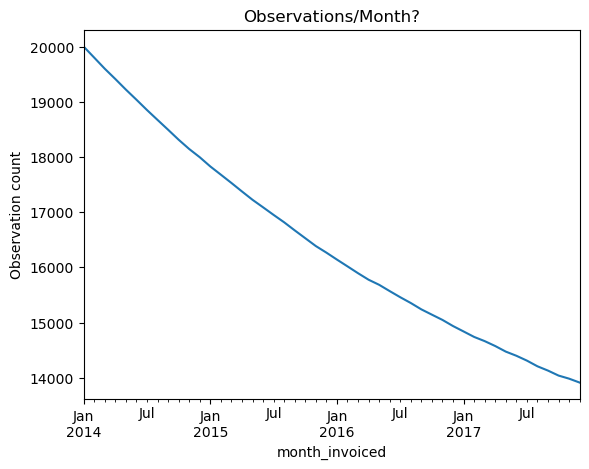

In [12]:
df.resample('M').size().plot()
plt.ylabel('Observation count')
plt.title('Observations/Month?')

[Text(0.5, 1.0, 'Revenue Over time'),
 Text(0, 0.5, 'Revenue'),
 Text(0.5, 0, '')]

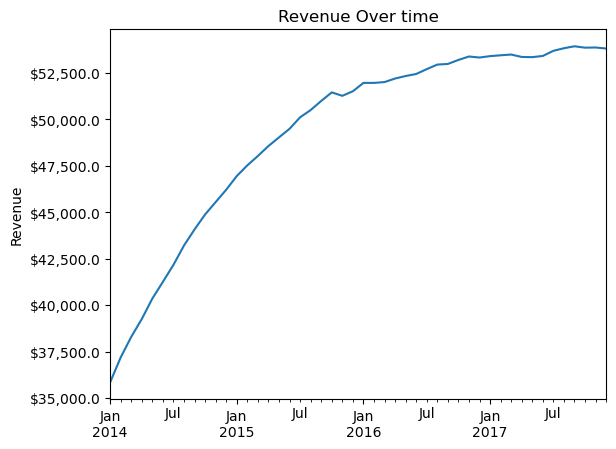

In [15]:
ax = df.resample('M').amount.sum().plot()
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,}'))
ax.set(title='Revenue Over time', ylabel='Revenue', xlabel='')

In [16]:
df = df.resample('M')[['amount']].sum()

In [17]:
train_size = int(len(df) * 0.5)
train_size

24

In [18]:
validate_size = int(len(df) * 0.3)
validate_size

14

In [19]:
test_size = int(len(df) - train_size - validate_size)
test_size

10

In [20]:
len(df) == train_size + validate_size + test_size

True

In [21]:
validate_end_index = train_size + validate_size
validate_end_index

38

In [22]:
train = df[:train_size]

In [23]:
validate = df[train_size:validate_end_index]

In [24]:
validate

,amount
month_invoiced,
2016-01-31,51955
2016-02-29,51955
2016-03-31,52000
2016-04-30,52190
2016-05-31,52325
2016-06-30,52435
2016-07-31,52695
2016-08-31,52940
2016-09-30,52975


In [25]:
test = df[validate_end_index:]

In [26]:
train.size, validate.size, test.size

(24, 14, 10)

In [27]:
len(train) + len(validate) + len(test) == len(df)

True

In [28]:
print(df.head(1) == train.head(1))

                amount
month_invoiced        
2014-01-31        True


In [29]:
pd.concat([train.tail(1), validate.head(1)])

,amount
month_invoiced,
2015-12-31,51505
2016-01-31,51955


In [30]:
pd.concat([validate.tail(1), test.head(1)])

,amount
month_invoiced,
2017-02-28,53440
2017-03-31,53480


In [31]:
pd.concat([test.tail(1), df.tail(1)])

,amount
month_invoiced,
2017-12-31,53805
2017-12-31,53805


In [32]:
train.columns

Index(['amount'], dtype='object')

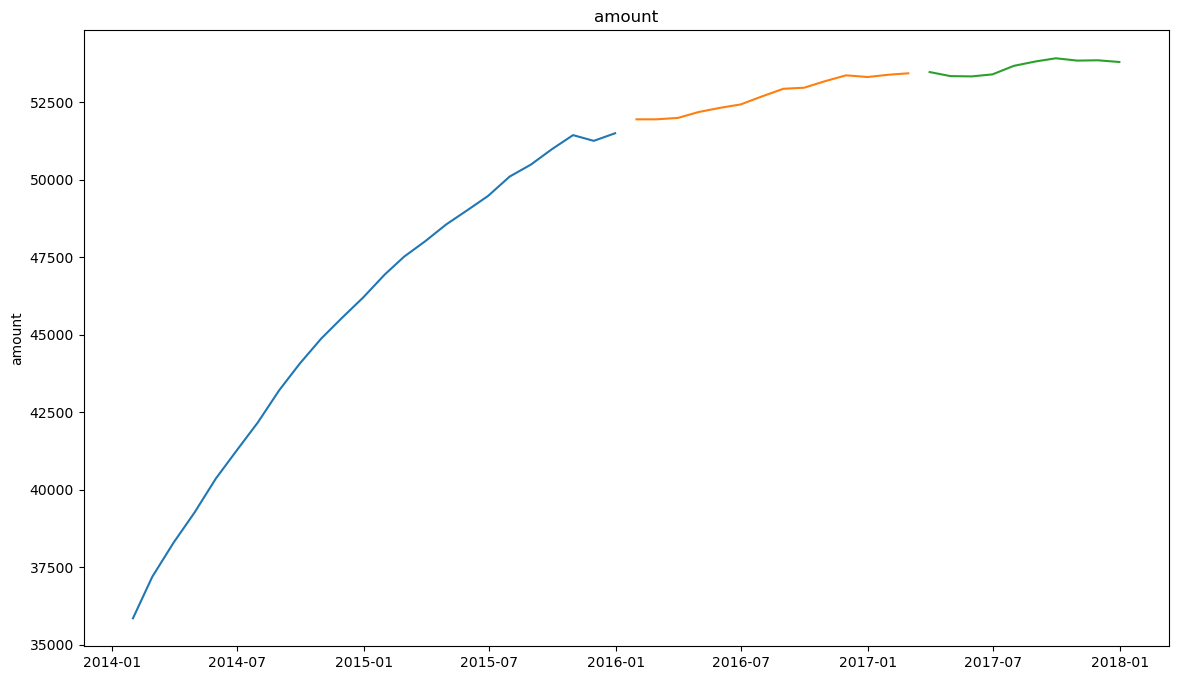

In [33]:
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [34]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [35]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var], label=target_var)
    plt.title(target_var)
    plt.legend()
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [36]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [37]:
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [38]:
train['amount'][-1:][0]

51505

In [39]:
amount = train['amount'][-1:][0]
amount

51505

In [40]:
yhat_df = pd.DataFrame({'amount': [amount]}, index=validate.index)

yhat_df.head()

,amount
month_invoiced,
2016-01-31,51505
2016-02-29,51505
2016-03-31,51505
2016-04-30,51505
2016-05-31,51505


In [41]:
yhat_df.describe()

,amount
count,14.0
mean,51505.0
std,0.0
min,51505.0
25%,51505.0
50%,51505.0
75%,51505.0
max,51505.0


amount -- RMSE: 1343


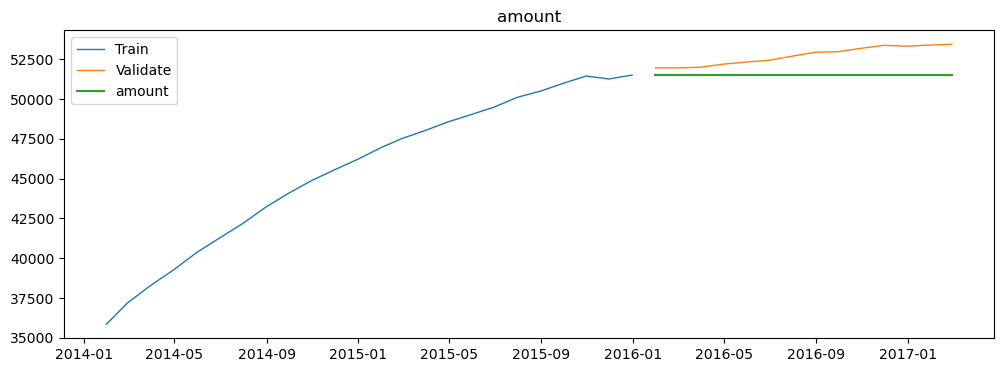

In [42]:
plot_and_eval('amount')

amount -- RMSE: 1343


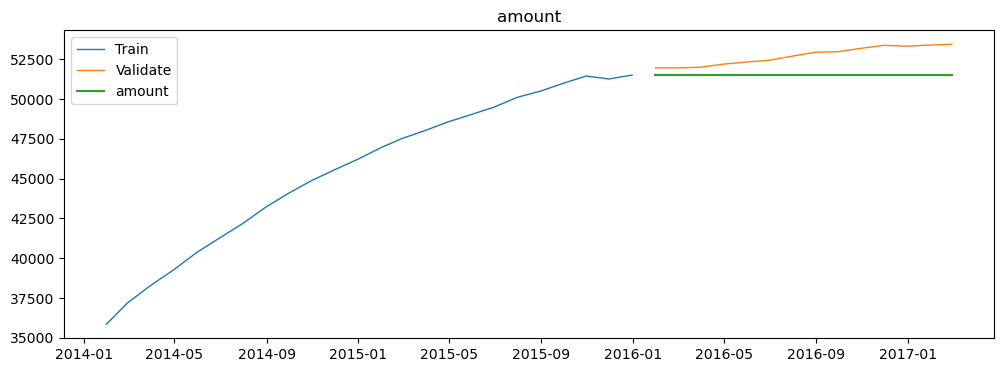

In [43]:
for col in train.columns:
    plot_and_eval(col)

In [44]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0


In [45]:
amount = round(train['amount'].mean(), 2)
amount

45568.54

In [46]:
def make_predictions(amount=None):
    yhat_df = pd.DataFrame({'amount': [amount]}, index=validate.index)
    return yhat_df

In [47]:
yhat_df = make_predictions(amount)

In [48]:
yhat_df.head()

,amount
month_invoiced,
2016-01-31,45568.54
2016-02-29,45568.54
2016-03-31,45568.54
2016-04-30,45568.54
2016-05-31,45568.54


In [49]:
yhat_df.describe()

,amount
count,1.400000e+01
mean,4.556854e+04
std,7.550618e-12
min,4.556854e+04
25%,4.556854e+04
50%,4.556854e+04
75%,4.556854e+04
max,4.556854e+04


amount -- RMSE: 7181


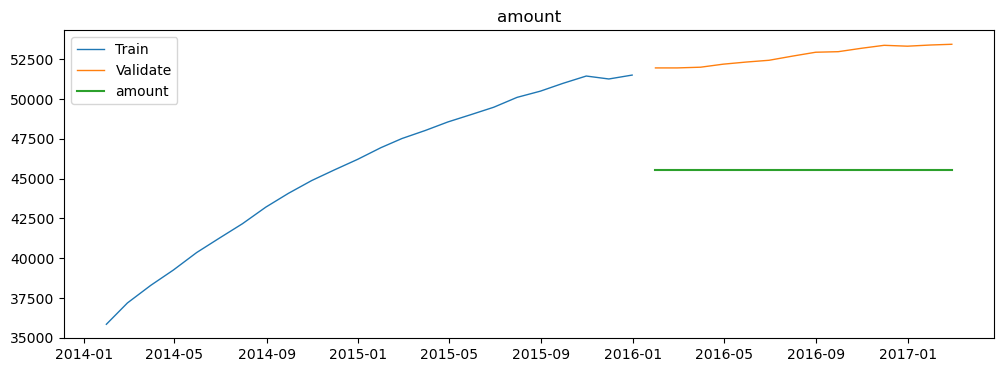

In [50]:
for col in train.columns:
    plot_and_eval(col)

In [51]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
1,simple_average,amount,7181.0


In [52]:
print(train['amount'].rolling(3).mean())

month_invoiced
2014-01-31             NaN
2014-02-28             NaN
2014-03-31    37111.666667
2014-04-30    38246.666667
2014-05-31    39301.666667
2014-06-30    40288.333333
2014-07-31    41260.000000
2014-08-31    42211.666667
2014-09-30    43151.666667
2014-10-31    44055.000000
2014-11-30    44833.333333
2014-12-31    45545.000000
2015-01-31    46233.333333
2015-02-28    46891.666667
2015-03-31    47496.666667
2015-04-30    48035.000000
2015-05-31    48536.666667
2015-06-30    49023.333333
2015-07-31    49538.333333
2015-08-31    50028.333333
2015-09-30    50528.333333
2015-10-31    50975.000000
2015-11-30    51230.000000
2015-12-31    51403.333333
Freq: M, Name: amount, dtype: float64


In [53]:
period=3
train['amount'].rolling(period).mean()[-1]

51403.333333333336

In [54]:
period = 3

amount = round(train['amount'].rolling(period).mean()[-1], 2)
print(amount)

51403.33


In [55]:
yhat_df = make_predictions(amount)
yhat_df.head()

,amount
month_invoiced,
2016-01-31,51403.33
2016-02-29,51403.33
2016-03-31,51403.33
2016-04-30,51403.33
2016-05-31,51403.33


amount -- RMSE: 1436


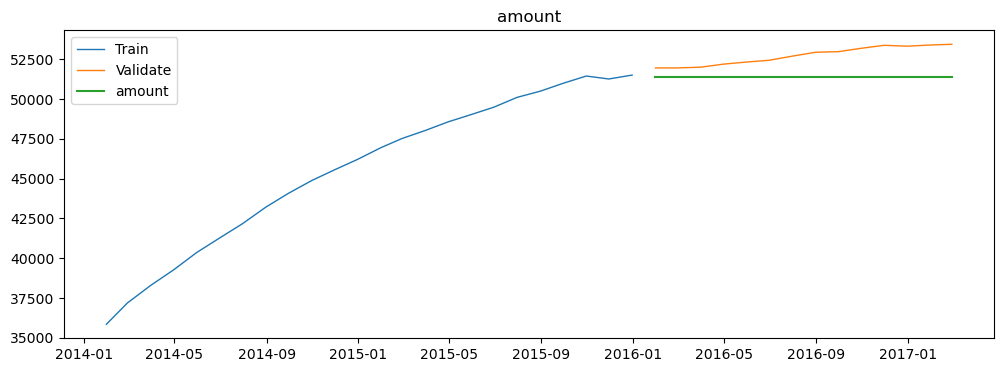

In [56]:
for col in train.columns:
    plot_and_eval(col)

In [57]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '3_month_moving_avg', target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
1,simple_average,amount,7181.0
2,3_month_moving_avg,amount,1436.0


In [58]:
periods = [1, 2, 3, 4, 10]

for p in periods: 
    amount = round(train['amount'].rolling(p).mean()[-1], 2)
    yhat_df = make_predictions(amount)
    model_type = str(p) + '_month_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type,
                                target_var = col)

In [59]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
1,simple_average,amount,7181.0
2,3_month_moving_avg,amount,1436.0
3,1_month_moving_avg,amount,1343.0
4,2_month_moving_avg,amount,1455.0
5,3_month_moving_avg,amount,1436.0
6,4_month_moving_avg,amount,1533.0
7,10_month_moving_avg,amount,2696.0


In [61]:
min_rmse = eval_df[eval_df.target_var == 'amount']['rmse'].min()
min_rmse

1343.0

In [62]:
eval_df[eval_df.rmse == min_rmse]

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
3,1_month_moving_avg,amount,1343.0


amount 



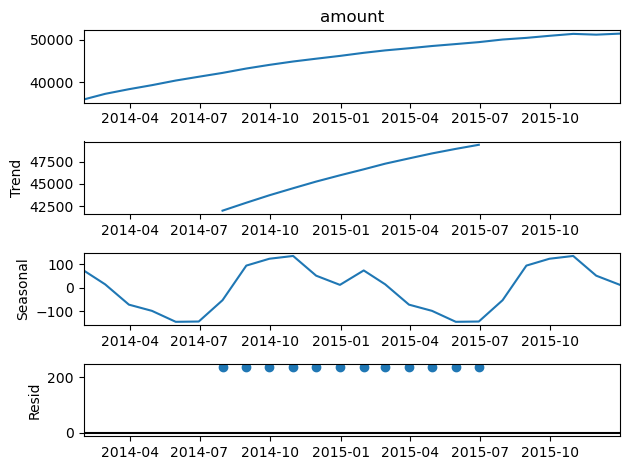

In [63]:
print(col, '\n')
sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()
plt.show()

In [64]:
train.columns

Index(['amount'], dtype='object')

In [65]:
col = 'amount' 
model = Holt(train[col], exponential=False, damped=True)

In [66]:
model = model.fit(optimized=True)

In [67]:
yhat_items = model.predict(start = validate.index[0], end = validate.index[-1])

In [68]:
yhat_df[col] = round(yhat_items, 2)

In [69]:
yhat_df

,amount
month_invoiced,
2016-01-31,51748.62
2016-02-29,51962.00
2016-03-31,52173.35
2016-04-30,52382.69
2016-05-31,52590.04
2016-06-30,52795.43
2016-07-31,52998.86
2016-08-31,53200.36
2016-09-30,53399.95


amount -- RMSE: 456


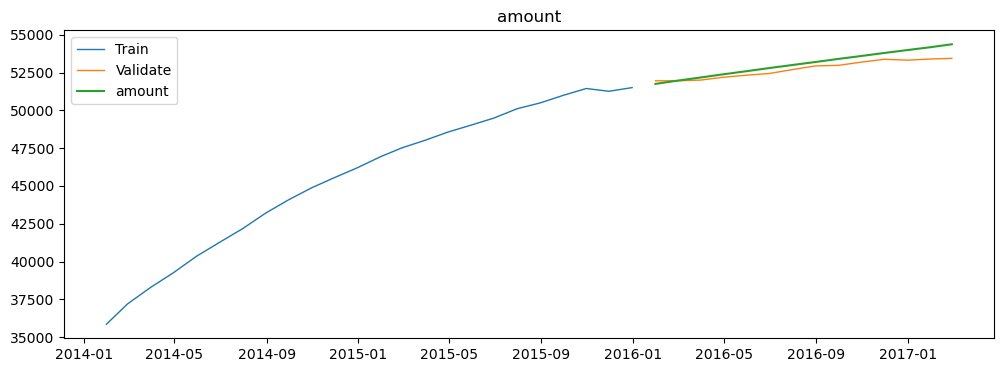

In [70]:
plot_and_eval(target_var = col)


In [71]:
eval_df = append_eval_df(model_type = 'holts_optimized', target_var = col)

In [72]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
8,holts_optimized,amount,456.0
0,last_observed_value,amount,1343.0
3,1_month_moving_avg,amount,1343.0
2,3_month_moving_avg,amount,1436.0
5,3_month_moving_avg,amount,1436.0
4,2_month_moving_avg,amount,1455.0
6,4_month_moving_avg,amount,1533.0
7,10_month_moving_avg,amount,2696.0
1,simple_average,amount,7181.0


In [73]:
df.index

DatetimeIndex(['2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30',
               '2014-05-31', '2014-06-30', '2014-07-31', '2014-08-31',
               '2014-09-30', '2014-10-31', '2014-11-30', '2014-12-31',
               '2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-31', '2015-11-30', '2015-12-31',
               '2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30',
               '2016-05-31', '2016-06-30', '2016-07-31', '2016-08-31',
               '2016-09-30', '2016-10-31', '2016-11-30', '2016-12-31',
               '2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
               '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', name='month_invoiced', freq='M')

In [74]:
train = df[:'2015']
validate = df['2016']
test = df['2017']

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()

(24, 1)
(12, 1)
(12, 1)


,amount
month_invoiced,
2014-01-31,35850
2014-02-28,37190
2014-03-31,38295
2014-04-30,39255
2014-05-31,40355


In [75]:
yhat_df = train['2015'] + train.diff(12).mean()

In [76]:
train.loc['2015'].head()

,amount
month_invoiced,
2015-01-31,46945
2015-02-28,47520
2015-03-31,48025
2015-04-30,48560
2015-05-31,49025


In [77]:
yhat_df.head()

,amount
month_invoiced,
2015-01-31,55033.75
2015-02-28,55608.75
2015-03-31,56113.75
2015-04-30,56648.75
2015-05-31,57113.75


In [78]:
pd.concat([yhat_df.head(1), validate.head(1)])

,amount
month_invoiced,
2015-01-31,55033.75
2016-01-31,51955.00


In [79]:
yhat_df.index = validate.index

In [80]:
yhat_df.describe()

,amount
count,12.000000
mean,57701.666667
std,1596.656248
min,55033.750000
25%,56515.000000
50%,57883.750000
75%,59142.500000
max,59593.750000


In [81]:
yhat_df.head()

,amount
month_invoiced,
2016-01-31,55033.75
2016-02-29,55608.75
2016-03-31,56113.75
2016-04-30,56648.75
2016-05-31,57113.75


amount -- RMSE: 5192


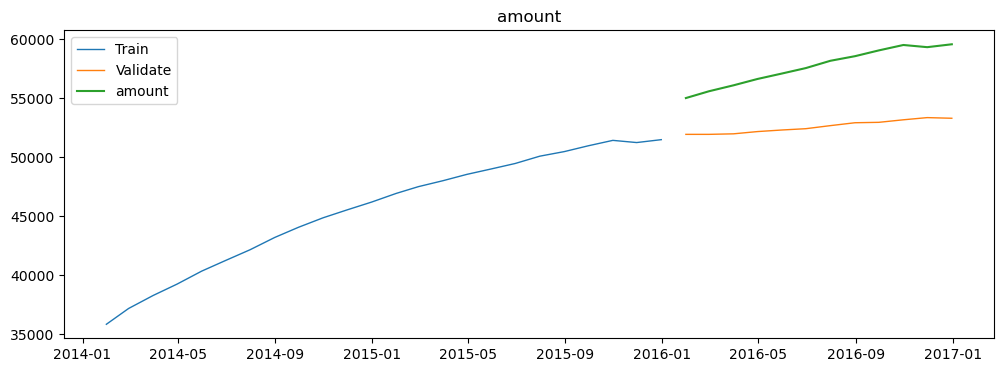

In [82]:
plot_and_eval(target_var = col)
eval_df = append_eval_df(model_type = "previous_year", target_var = col)

In [83]:
min_rmse = eval_df['rmse'].min()

In [84]:
eval_df[(eval_df.rmse == min_rmse)]

,model_type,target_var,rmse
8,holts_optimized,amount,456.0


In [85]:
yhat_items = model.predict(start = test.index[0], end = test.index[-1])

In [86]:
yhat_df = pd.DataFrame(index=test.index, columns=test.columns)
yhat_df.amount = yhat_items

In [87]:
yhat_df

,amount
month_invoiced,
2017-01-31,54179.514829
2017-02-28,54369.799440
2017-03-31,54558.276350
2017-04-30,54744.962734
2017-05-31,54929.875601
2017-06-30,55113.031800
2017-07-31,55294.448019
2017-08-31,55474.140787
2017-09-30,55652.126478


In [88]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

In [89]:
rmse_amount = sqrt(mean_squared_error(test['amount'], yhat_df['amount']))

In [90]:
print('rmse-amount: ', rmse_amount)

rmse-amount:  1645.3897303951746


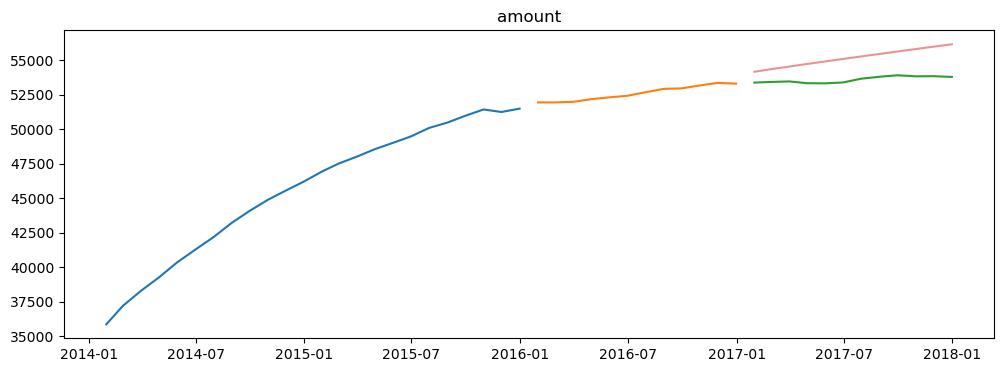

In [91]:
final_plot(col)

In [92]:
yhat_df.index = test.index + pd.Timedelta('1Y')

In [93]:
yhat = model.predict(start = test.index[0], end = test.index[-1])

In [94]:
yhat_df.amount = yhat.values

In [95]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5, label='projection')
    plt.title(target_var)
    plt.legend()
    plt.show()

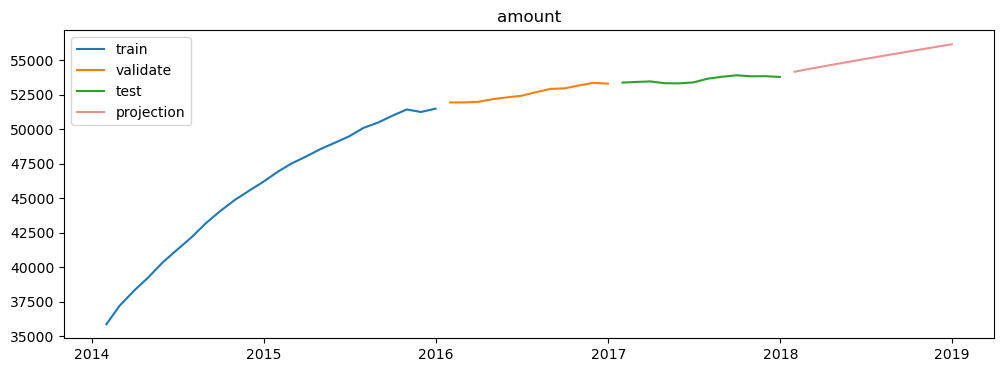

In [96]:
for col in train.columns:
    final_plot(col)